In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from keras_vggface.vggface import VGGFace
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from sklearn.datasets import fetch_lfw_people
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from skimage.transform import resize
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import itertools

In [2]:
# Load LFW dataset
lfw_dataset = fetch_lfw_people(min_faces_per_person=70, resize=0.4, color=True)

In [3]:
# Extract features and labels
X = lfw_dataset.images
y = lfw_dataset.target
target_names = lfw_dataset.target_names

In [4]:
# Resize images to match expected input size of the vggface Model (224, 224)
X_resized = np.array([resize(image, (224, 224)) for image in X])

In [5]:
# Normalize pixel values to range [0, 1]
X_rescaled = X_resized / 255.0

In [6]:
# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [7]:
senet50_model = VGGFace(model='senet50', include_top=False, input_shape=(224, 224, 3))
last_layer = senet50_model.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
out = Dense(len(target_names), activation='softmax', name='classifier')(x)
model = Model(senet50_model.input, out)

In [8]:
# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Configure K-Fold Cross-Validation
num_folds = 10
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [10]:
# Initialize lists to store true positive rates and area under curve values
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
# Initialize list to store fold accuracies
fold_accs = []
# Initialize lists to store precision, recall, f1-score, and confusion matrices
precisions = []
recalls = []
f1_scores = []
conf_matrices = []

In [11]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
# Training and Evaluation Loop

for fold, (train_index, val_index) in enumerate(skf.split(X_rescaled, y)):
    print(f"Fold {fold+1}/{num_folds}")
    X_train, X_val = X_rescaled[train_index], X_rescaled[val_index]
    y_train, y_val = y_categorical[train_index], y_categorical[val_index]

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

    # Evaluate the model
    _, accuracy = model.evaluate(X_val, y_val)
    fold_accs.append(accuracy)

    # Compute predicted probabilities
    y_prob = model.predict(X_val)
    y_pred = np.argmax(y_prob, axis=1)

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y_val[:, 1], y_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Interpolate tpr to match mean_fpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)

    # Append tpr and auc to lists
    tprs.append(interp_tpr)
    aucs.append(roc_auc)

    # Compute precision, recall, f1-score, and confusion matrix
    precision = precision_score(np.argmax(y_val, axis=1), y_pred, average='weighted')
    recall = recall_score(np.argmax(y_val, axis=1), y_pred, average='weighted')
    f1 = f1_score(np.argmax(y_val, axis=1), y_pred, average='weighted')
    conf_matrix = confusion_matrix(np.argmax(y_val, axis=1), y_pred)

    # Append precision, recall, f1-score, and confusion matrix to lists
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    conf_matrices.append(conf_matrix)

Fold 1/10
Epoch 1/10
37/37 [==============================] - 27s 327ms/step - loss: 3.6717 - accuracy: 0.3469 - val_loss: 13250672640.0000 - val_accuracy: 0.4109
Epoch 2/10
37/37 [==============================] - 10s 274ms/step - loss: 1.7984 - accuracy: 0.4038 - val_loss: 50927748.0000 - val_accuracy: 0.0930
Epoch 3/10
37/37 [==============================] - 10s 272ms/step - loss: 1.7681 - accuracy: 0.4072 - val_loss: 1976.2683 - val_accuracy: 0.4109
Epoch 4/10
37/37 [==============================] - 10s 273ms/step - loss: 1.7533 - accuracy: 0.4047 - val_loss: 65967.9375 - val_accuracy: 0.0930
Epoch 5/10
37/37 [==============================] - 10s 281ms/step - loss: 1.7280 - accuracy: 0.4055 - val_loss: 2127.8948 - val_accuracy: 0.0930
Epoch 6/10
37/37 [==============================] - 10s 272ms/step - loss: 1.7001 - accuracy: 0.4072 - val_loss: 1.7107 - val_accuracy: 0.4109
Epoch 7/10
37/37 [==============================] - 10s 273ms/step - loss: 1.6935 - accuracy: 0.3995 - va

c:\Users\mynam\OneDrive\Desktop\Freelance\.conda\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 11s 284ms/step - loss: 1.5759 - accuracy: 0.4495 - val_loss: 4.0032 - val_accuracy: 0.0620
Epoch 2/10
37/37 [==============================] - 10s 274ms/step - loss: 1.4935 - accuracy: 0.4728 - val_loss: 2.3677 - val_accuracy: 0.1163
Epoch 3/10
37/37 [==============================] - 10s 274ms/step - loss: 1.3717 - accuracy: 0.5186 - val_loss: 9.5758 - val_accuracy: 0.4109
Epoch 4/10
37/37 [==============================] - 10s 274ms/step - loss: 1.2910 - accuracy: 0.5634 - val_loss: 21.0968 - val_accuracy: 0.0620
Epoch 5/10
37/37 [==============================] - 10s 273ms/step - loss: 1.0647 - accuracy: 0.6264 - val_loss: 3.5317 - val_accuracy: 0.1163
Epoch 6/10
37/37 [==============================] - 10s 273ms/step - loss: 0.8039 - accuracy: 0.7144 - val_loss: 3.9422 - val_accuracy: 0.1163
Epoch 7/10
37/37 [==============================] - 10s 274ms/step - loss: 0.5825 - accuracy: 0.7998 - val_loss: 6.9436 - val_accuracy: 0.054

c:\Users\mynam\OneDrive\Desktop\Freelance\.conda\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 10s 276ms/step - loss: 0.2118 - accuracy: 0.9275 - val_loss: 13.6836 - val_accuracy: 0.1473
Epoch 2/10
37/37 [==============================] - 10s 274ms/step - loss: 0.1105 - accuracy: 0.9646 - val_loss: 21.3070 - val_accuracy: 0.0930
Epoch 3/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0955 - accuracy: 0.9689 - val_loss: 5.1828 - val_accuracy: 0.1783
Epoch 4/10
37/37 [==============================] - 10s 274ms/step - loss: 0.1174 - accuracy: 0.9594 - val_loss: 5.4867 - val_accuracy: 0.4109
Epoch 5/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0664 - accuracy: 0.9793 - val_loss: 2.7292 - val_accuracy: 0.4109
Epoch 6/10
37/37 [==============================] - 10s 274ms/step - loss: 0.0454 - accuracy: 0.9871 - val_loss: 4.8754 - val_accuracy: 0.1085
Epoch 7/10
37/37 [==============================] - 10s 274ms/step - loss: 0.0892 - accuracy: 0.9741 - val_loss: 5.0293 - val_accuracy: 0.06

c:\Users\mynam\OneDrive\Desktop\Freelance\.conda\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 10s 275ms/step - loss: 0.0750 - accuracy: 0.9793 - val_loss: 6.9367 - val_accuracy: 0.1860
Epoch 2/10
37/37 [==============================] - 10s 273ms/step - loss: 0.1132 - accuracy: 0.9620 - val_loss: 19.5822 - val_accuracy: 0.1163
Epoch 3/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0512 - accuracy: 0.9827 - val_loss: 11.6864 - val_accuracy: 0.1163
Epoch 4/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0263 - accuracy: 0.9914 - val_loss: 24.2722 - val_accuracy: 0.1163
Epoch 5/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0244 - accuracy: 0.9931 - val_loss: 34.9075 - val_accuracy: 0.1163
Epoch 6/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0290 - accuracy: 0.9905 - val_loss: 9.2488 - val_accuracy: 0.1318
Epoch 7/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0305 - accuracy: 0.9905 - val_loss: 10.8791 - val_accuracy: 0

c:\Users\mynam\OneDrive\Desktop\Freelance\.conda\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 11s 284ms/step - loss: 0.0280 - accuracy: 0.9931 - val_loss: 6.2335 - val_accuracy: 0.2093
Epoch 2/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0209 - accuracy: 0.9940 - val_loss: 3.3562 - val_accuracy: 0.1628
Epoch 3/10
37/37 [==============================] - 10s 277ms/step - loss: 0.0179 - accuracy: 0.9957 - val_loss: 3.5857 - val_accuracy: 0.4419
Epoch 4/10
37/37 [==============================] - 10s 278ms/step - loss: 0.0136 - accuracy: 0.9948 - val_loss: 1.6510 - val_accuracy: 0.4884
Epoch 5/10
37/37 [==============================] - 10s 283ms/step - loss: 0.0844 - accuracy: 0.9707 - val_loss: 3.4554 - val_accuracy: 0.3798
Epoch 6/10
37/37 [==============================] - 10s 275ms/step - loss: 0.0689 - accuracy: 0.9784 - val_loss: 1.7823 - val_accuracy: 0.5426
Epoch 7/10
37/37 [==============================] - 10s 274ms/step - loss: 0.0218 - accuracy: 0.9914 - val_loss: 0.6522 - val_accuracy: 0.7752

c:\Users\mynam\OneDrive\Desktop\Freelance\.conda\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 10s 275ms/step - loss: 0.0583 - accuracy: 0.9827 - val_loss: 5.2060 - val_accuracy: 0.2791
Epoch 2/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0198 - accuracy: 0.9957 - val_loss: 3.3001 - val_accuracy: 0.5736
Epoch 3/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0057 - accuracy: 0.9991 - val_loss: 1.7568 - val_accuracy: 0.6822
Epoch 4/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.1720 - val_accuracy: 0.9457
Epoch 5/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0031 - accuracy: 0.9983 - val_loss: 0.0753 - val_accuracy: 0.9767
Epoch 6/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 0.0537 - val_accuracy: 0.9845
Epoch 7/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0230 - accuracy: 0.9948 - val_loss: 0.7833 - val_accuracy: 0.8140

c:\Users\mynam\OneDrive\Desktop\Freelance\.conda\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/10
37/37 [==============================] - 10s 277ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.3689 - val_accuracy: 0.8672
Epoch 2/10
37/37 [==============================] - 10s 275ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0409 - val_accuracy: 0.9844
Epoch 3/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 0.0110 - val_accuracy: 0.9922
Epoch 4/10
37/37 [==============================] - 10s 273ms/step - loss: 6.0416e-04 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 5/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0019 - accuracy: 0.9991 - val_loss: 7.7024e-04 - val_accuracy: 1.0000
Epoch 6/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0352 - accuracy: 0.9888 - val_loss: 1.2814 - val_accuracy: 0.7812
Epoch 7/10
37/37 [==============================] - 10s 273ms/step - loss: 0.0120 - accuracy: 0.9948 - val_loss: 0.2772 - val_accuracy

Normalized confusion matrix


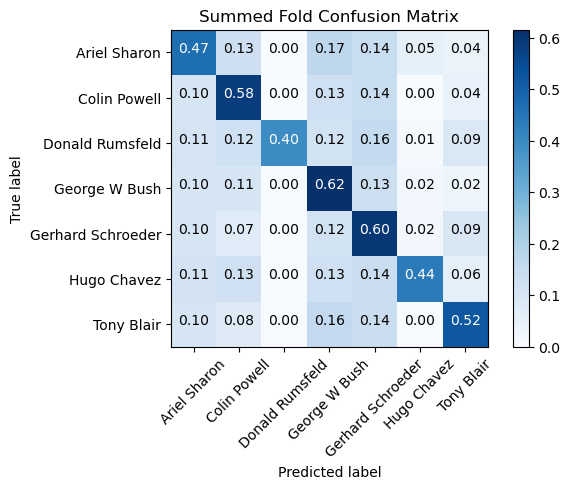

In [13]:
# Plot the summed confusion matrix
sum_conf_matrix = np.sum(conf_matrices, axis=0)
plt.figure()
plot_confusion_matrix(sum_conf_matrix, classes=target_names, normalize=True,
                      title='Summed Fold Confusion Matrix')

In [14]:
# Compute mean accuracy, precision, recall, f1-score
mean_accuracy = np.mean(fold_accs)
mean_precisions = np.mean(precisions)
mean_recalls = np.mean(recalls)
mean_f1_scores = np.mean(f1_scores)
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean Precisions: {mean_precisions}")
print(f"Mean Recalls: {mean_recalls}")
print(f"Mean F1 Score: {mean_f1_scores}")

Mean Accuracy: 0.558599803969264
Mean Precisions: 0.5524842612410718
Mean Recalls: 0.5585998062015504
Mean F1 Score: 0.5129787863068606


In [15]:
# Print precision, recall, f1-score, and confusion matrix for each fold
for i in range(num_folds):
    print(f"\nFold {i+1}:")
    print(f"Precision: {precisions[i]}")
    print(f"Recall: {recalls[i]}")
    print(f"F1-Score: {f1_scores[i]}")
    print("Confusion Matrix:")
    print(conf_matrices[i])


Fold 1:
Precision: 0.0029445345832582177
Recall: 0.05426356589147287
F1-Score: 0.005585955312357501
Confusion Matrix:
[[ 7  0  0  0  0  0  0]
 [24  0  0  0  0  0  0]
 [12  0  0  0  0  0  0]
 [53  0  0  0  0  0  0]
 [11  0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0]
 [14  0  0  0  0  0  0]]

Fold 2:
Precision: 0.168799951925966
Recall: 0.4108527131782946
F1-Score: 0.23928784393900673
Confusion Matrix:
[[ 0  0  0  8  0  0  0]
 [ 0  0  0 23  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  0  0 53  0  0  0]
 [ 0  0  0 11  0  0  0]
 [ 0  0  0  7  0  0  0]
 [ 0  0  0 15  0  0  0]]

Fold 3:
Precision: 0.007444321397809769
Recall: 0.08527131782945736
F1-Score: 0.013693204322978556
Confusion Matrix:
[[ 0  0  0  0  8  0  0]
 [ 0  0  0  0 23  0  0]
 [ 0  0  0  0 12  0  0]
 [ 0  2  0  0 51  0  0]
 [ 0  0  0  0 11  0  0]
 [ 0  0  0  0  7  0  0]
 [ 0  1  0  0 14  0  0]]

Fold 4:
Precision: 0.4859024490635933
Recall: 0.2248062015503876
F1-Score: 0.11428197463309182
Confusion Matrix:
[[ 0  8  0  0  0  0  0]
 [ 0 

In [16]:
# Compute mean and standard deviation of tpr
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

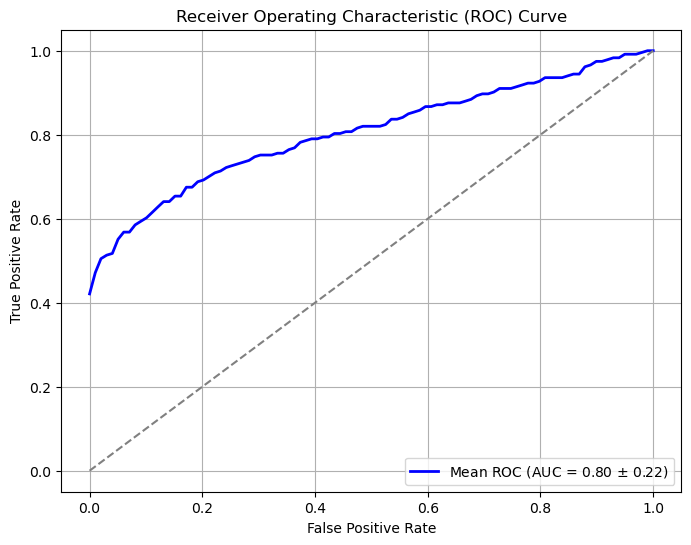

In [17]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()